# Assignment 4: Text2Code Model

Train a transformer model from scratch, beat the baselines.

Pay attention to model hyperparams as well as sequence generation procedure.

For each sample you generate 5 hypothesis and select the best of them for scoring.

**task 1** (2 points) beat baseline CHRF > 20.  
**task 2** (2 points) beat baseline CHRF > 30.  
**task 3** (2 points) beat baseline CHRF > 40.  

**task 4** (2 points): explore a shared vocabulary setting vs seperate vocabularies. Which one is better?  

**task 5** (2 points): Try finetuning a pretrained model (e.g. BERT, T5). Cut the last layers if the model doesn't fit into the memory. 

In [70]:
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import joblib

tqdm.pandas()

In [ ]:
# prepare dataset
df = datasets.load_dataset('code_x_glue_tc_text_to_code')

df_train, df_valid = df['train'], df['validation']

df_train = pd.DataFrame({'nl': df_train['nl'], 'code': df_train['code']})
df_valid = pd.DataFrame({'nl': df_valid['nl'], 'code': df_valid['code']})

for df in (df_train, df_valid):
    df['nl'] = df['nl'].apply(lambda x: x[:x.rfind('.')].strip())
    df['code'] = df['code'].apply(str.strip)
    
df_train = df_train.loc[df_train['nl'].apply(str.split).apply(len) > 3].reset_index(drop=True)
print(len(df_train))

In [2]:
with open('nl.txt', 'w') as f:
    for x in df_train['nl']:
        f.write(x + '\n')
        
with open('code.txt', 'w') as f:
    for x in df_train['code']:
        f.write(x + '\n')

Reusing dataset code_x_glue_tc_text_to_code (/home/denis.litvinov/.cache/huggingface/datasets/code_x_glue_tc_text_to_code/default/0.0.0/059898ce5bb35e72c699c69af37020002b38b251734ddaeedef30ae7e6292717)


  0%|          | 0/3 [00:00<?, ?it/s]

95785


In [3]:
from dataclasses import dataclass


@dataclass
class Config:
    pass

config = Config()
config.nl_pad = 0
config.code_pad = 0
config.nl_vocab_size = # TODO
config.code_vocab_size = # TODO

nl_tokenizer = # TODO
code_tokenizer = # TODO

In [7]:
for df in (df_train, df_valid):
    df['nl_encoded'] = df['nl'].progress_apply(lambda x: nl_tokenizer.encode(x).ids)
    df['code_encoded'] = df['code'].progress_apply(lambda x: code_tokenizer.encode(x).ids)

100%|██████████| 2000/2000 [00:00<00:00, 453806.22it/s]


['df_test']

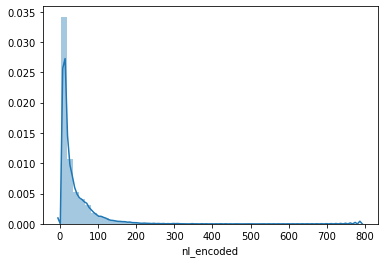

In [8]:
sns.distplot(df_train['nl_encoded'].apply(len));

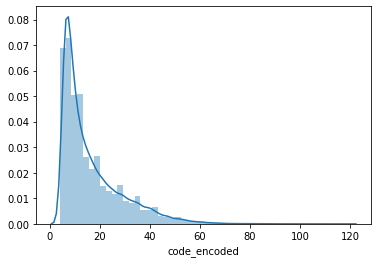

In [9]:
sns.distplot(df_train['code_encoded'].apply(len));

In [ ]:
# choose max nl length. It's a tradeoff between memory space utilization and information
config.nl_max_len = # TODO
config.code_max_len = # TODO

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch


class MyDataset(Dataset):
    def __init__(self, df, config):
        self.df = df
        self.config = config
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        
        nl = self.df['nl_encoded'].iloc[i]
        code = self.df['code_encoded'].iloc[i]
        
        # padding
        nl = nl[:self.config.nl_max_len] + [self.config.nl_pad]*max(0, self.config.nl_max_len-len(nl))
        code = code[:self.config.code_max_len] + [self.config.code_pad]*max(0, self.config.code_max_len-len(code))
        
        nl = torch.tensor(nl).long()
        code = torch.tensor(code).long()
        
        return (nl, code[:-1]), code[1:]

In [11]:
config.batch_size = # TODO

loaders = {
    'train': DataLoader(MyDataset(df_train, config), batch_size=config.batch_size, shuffle=True),
    'valid': DataLoader(MyDataset(df_valid, config), batch_size=config.batch_size, shuffle=False),
}

In [12]:
import torch.nn as nn
from transformers import BertConfig, EncoderDecoderConfig, EncoderDecoderModel


# how to make encoder-decoder model from Huggingface 
class Text2Code(nn.Module):
    def __init__(self, config):
        super(Text2Code, self).__init__()
        
        self.config = config
        
        enc_config = BertConfig(
            # TODO
        )
        dec_config = BertConfig(
            # TODO
        )
        dec_config.is_decoder = True
        dec_config.add_cross_attention = True
        
        self.encdec = EncoderDecoderModel(
            config=EncoderDecoderConfig.from_encoder_decoder_configs(enc_config, dec_config)
        )
        
        # TODO: here you share encoder and decoder embeddings if necessary 
        
    def forward(self, x):
        src, tgt = x
        
        x = self.encdec(src, 
                        src != self.config.nl_pad, # attention mask
                        tgt, 
                        tgt != self.config.code_pad, # attention mask
                        return_dict=True)
        x = x.logits.transpose(1,2)
        return x
        

In [13]:
import catalyst.dl as dl
import torch.optim as optim


config.num_epochs = # TODO
config.d_model = # TODO
# ...



model = Text2Code(config)

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    loaders=loaders,
    criterion=nn.CrossEntropyLoss(ignore_index=config.code_pad), # ignore padding
    optimizer=optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5), # Adam + disentangled weight decay
    num_epochs=config.num_epochs,
    logdir='./log1',
    valid_loader='valid',
    valid_metric='loss',
    verbose=True,
#     check=True, # check the pipeline
)

/home/denis.litvinov/anaconda3/lib/python3.7/site-packages/promise/promise_list.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/denis.litvinov/anaconda3/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping


1/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (1/15) loss: 7.18411151250203 | loss/mean: 7.18411151250203 | loss/std: 0.6487203144819947 | lr: 0.0001 | momentum: 0.9


1/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (1/15) loss: 6.715638637542725 | loss/mean: 6.715638637542725 | loss/std: 0.048927480147199755 | lr: 0.0001 | momentum: 0.9
* Epoch (1/15) 


2/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (2/15) loss: 5.838479640960694 | loss/mean: 5.838479640960694 | loss/std: 0.29798954547738027 | lr: 0.0001 | momentum: 0.9


2/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (2/15) loss: 5.7724013924598685 | loss/mean: 5.7724013924598685 | loss/std: 0.05657286589370021 | lr: 0.0001 | momentum: 0.9
* Epoch (2/15) 


3/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (3/15) loss: 5.017591190338139 | loss/mean: 5.017591190338139 | loss/std: 0.18718304968503413 | lr: 0.0001 | momentum: 0.9


3/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (3/15) loss: 5.252163350582123 | loss/mean: 5.252163350582123 | loss/std: 0.060746734249692756 | lr: 0.0001 | momentum: 0.9
* Epoch (3/15) 


4/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (4/15) loss: 4.441768369038899 | loss/mean: 4.441768369038899 | loss/std: 0.14387634203044647 | lr: 0.0001 | momentum: 0.9


4/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (4/15) loss: 4.900458753108978 | loss/mean: 4.900458753108978 | loss/std: 0.0672465270497876 | lr: 0.0001 | momentum: 0.9
* Epoch (4/15) 


5/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (5/15) loss: 3.992025461196898 | loss/mean: 3.992025461196898 | loss/std: 0.12144260826615344 | lr: 0.0001 | momentum: 0.9


5/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (5/15) loss: 4.6611634492874146 | loss/mean: 4.6611634492874146 | loss/std: 0.07400563720307242 | lr: 0.0001 | momentum: 0.9
* Epoch (5/15) 


6/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (6/15) loss: 3.6288410161336278 | loss/mean: 3.6288410161336278 | loss/std: 0.10900842754352384 | lr: 0.0001 | momentum: 0.9


6/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (6/15) loss: 4.4838690757751465 | loss/mean: 4.4838690757751465 | loss/std: 0.07158066179223427 | lr: 0.0001 | momentum: 0.9
* Epoch (6/15) 


7/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (7/15) loss: 3.3247926654815685 | loss/mean: 3.3247926654815685 | loss/std: 0.10482497700646784 | lr: 0.0001 | momentum: 0.9


7/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (7/15) loss: 4.363085389137268 | loss/mean: 4.363085389137268 | loss/std: 0.07663190526371527 | lr: 0.0001 | momentum: 0.9
* Epoch (7/15) 


8/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (8/15) loss: 3.06505414326986 | loss/mean: 3.06505414326986 | loss/std: 0.09367752029800029 | lr: 0.0001 | momentum: 0.9


8/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (8/15) loss: 4.266527712345123 | loss/mean: 4.266527712345123 | loss/std: 0.07820980165476882 | lr: 0.0001 | momentum: 0.9
* Epoch (8/15) 


9/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (9/15) loss: 2.842353055318194 | loss/mean: 2.842353055318194 | loss/std: 0.09612304337036554 | lr: 0.0001 | momentum: 0.9


9/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (9/15) loss: 4.199871301651001 | loss/mean: 4.199871301651001 | loss/std: 0.08317152553075768 | lr: 0.0001 | momentum: 0.9
* Epoch (9/15) 


10/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (10/15) loss: 2.646757908503214 | loss/mean: 2.646757908503214 | loss/std: 0.09741556500178135 | lr: 0.0001 | momentum: 0.9


10/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (10/15) loss: 4.162543177604675 | loss/mean: 4.162543177604675 | loss/std: 0.08556977636648402 | lr: 0.0001 | momentum: 0.9
* Epoch (10/15) 


11/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (11/15) loss: 2.472614102045699 | loss/mean: 2.472614102045699 | loss/std: 0.09452890414989903 | lr: 0.0001 | momentum: 0.9


11/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (11/15) loss: 4.13047307729721 | loss/mean: 4.13047307729721 | loss/std: 0.08727868691431526 | lr: 0.0001 | momentum: 0.9
* Epoch (11/15) 


12/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (12/15) loss: 2.3165030841827416 | loss/mean: 2.3165030841827416 | loss/std: 0.08985955803047857 | lr: 0.0001 | momentum: 0.9


12/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (12/15) loss: 4.120812922716141 | loss/mean: 4.120812922716141 | loss/std: 0.08530930934773 | lr: 0.0001 | momentum: 0.9
* Epoch (12/15) 


13/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (13/15) loss: 2.1773170200983682 | loss/mean: 2.1773170200983682 | loss/std: 0.08645459957378711 | lr: 0.0001 | momentum: 0.9


13/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (13/15) loss: 4.107413679361343 | loss/mean: 4.107413679361343 | loss/std: 0.0856441353079238 | lr: 0.0001 | momentum: 0.9
* Epoch (13/15) 


14/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (14/15) loss: 2.0476544195810935 | loss/mean: 2.0476544195810935 | loss/std: 0.08931011528836609 | lr: 0.0001 | momentum: 0.9


14/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (14/15) loss: 4.118893325328827 | loss/mean: 4.118893325328827 | loss/std: 0.08678093272649151 | lr: 0.0001 | momentum: 0.9
* Epoch (14/15) 


15/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (15/15) loss: 1.9301211388905841 | loss/mean: 1.9301211388905841 | loss/std: 0.09342873553494654 | lr: 0.0001 | momentum: 0.9


15/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (15/15) loss: 4.140888452529908 | loss/mean: 4.140888452529908 | loss/std: 0.09529004008639863 | lr: 0.0001 | momentum: 0.9
* Epoch (15/15) 
Top best models:
log1/checkpoints/train.13.pth	4.1074


In [48]:
from sacrebleu import CHRF

# CHRF - quality metric
# for the purposes of this assignment, we measure CHRF on the validation set
chrf = CHRF()

valid_loader = DataLoader(MyDataset(df_valid, config), batch_size=config.batch_size, shuffle=False)

# set model to eval mode: affects dropout layers
model.eval()

chrf_scores = []

with torch.no_grad():
    for batch in valid_loader:
        nl = batch[0][0] # encoded text
        
        # generate 5 hypothesis for each sample
        result = model.encdec.generate(
                      num_return_sequences=5,
                        # TODO: select generation algo
                     ).cpu()

        for i in tqdm(range(len(nl))):
            
            ground_truth = code_tokenizer.decode(batch[1][i].cpu().numpy())
            
            sample_scores = []
            for j in range(config.num_beams):
                pred = result[i*config.num_beams + j]
                pred = pred.cpu().numpy()
                pred = code_tokenizer.decode(pred)
                
                score = chrf.sentence_score(pred, [ground_truth]).score
                sample_scores.append(score)
            
            chrf_scores.append(max(sample_scores))
            
print(np.mean(chrf_scores))